In [1]:
import os
import random
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datasets import load_dataset
import librosa
import librosa.display
import IPython.display as ipd

from preprocess import segment_audio_data, visualize_audio_segments, get_features
from utils.constants import DATA_DIR, SEED

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting seeds
np.random.seed = SEED
random.seed = SEED

# setting up directories
os.makedirs(DATA_DIR, exist_ok=True) 

In [3]:
## Important Params
SEGMENT_NUM = 5

## Read in data

In [4]:
# downloading data
ds = load_dataset('marsyas/gtzan', cache_dir=DATA_DIR)
ds = ds.shuffle(seed=SEED)
print('File count: ', ds['train'].num_rows)
print('Example element: ', ds['train'][0])

File count:  999
Example element:  {'file': '/home/dani/music-genre-classification/data/downloads/extracted/197117f2e99aab4d1bf3be1b5ec80c391a0e4c13c8af00243fabf205d3d449d6/genres/disco/disco.00014.wav', 'audio': {'path': '/home/dani/music-genre-classification/data/downloads/extracted/197117f2e99aab4d1bf3be1b5ec80c391a0e4c13c8af00243fabf205d3d449d6/genres/disco/disco.00014.wav', 'array': array([ 0.20974731,  0.13619995,  0.14807129, ..., -0.16918945,
       -0.19021606, -0.21813965]), 'sampling_rate': 22050}, 'genre': 3}


## Processing file [example]

In [5]:
y, sr = librosa.load(ds['train'][101]['file']) # audio samples and sample rate
print('Data shape: ', y.shape) # all data points
print('Sample rate: ', sr) # sample rate in 1 sec of audio

Data shape:  (661794,)
Sample rate:  22050


Number of segments:  5


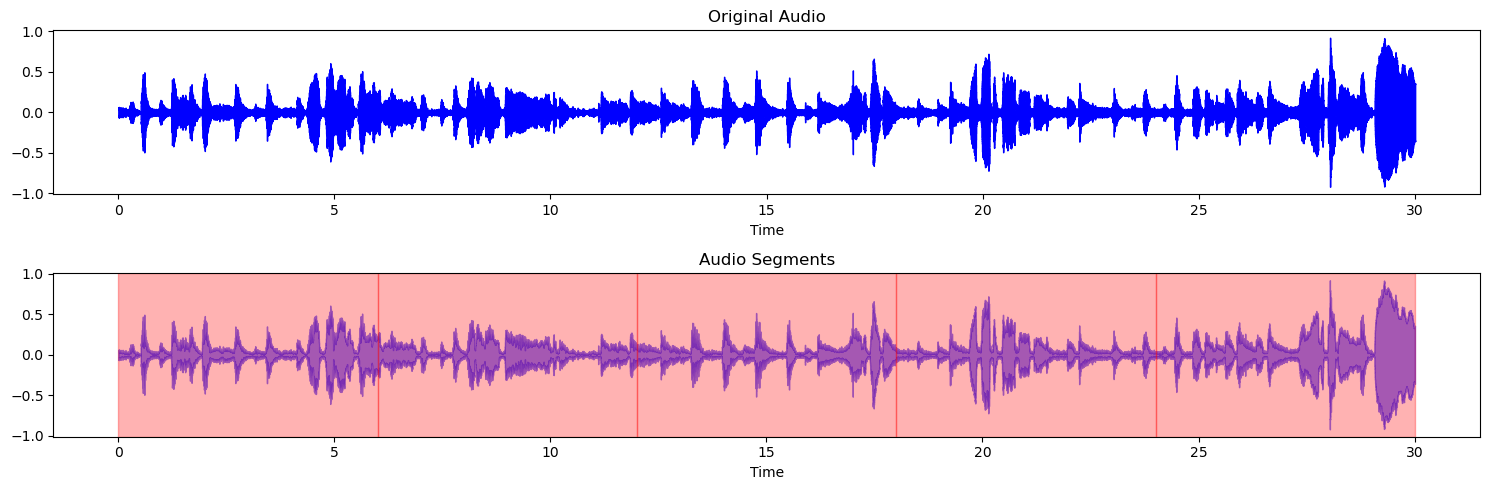

In [6]:
# segmentation
segment_ranges = segment_audio_data(y, segment_num=SEGMENT_NUM)
print('Number of segments: ', SEGMENT_NUM)

visualize_audio_segments(y, sr, segment_ranges)

## Processing all files

In [7]:
data = {
    'labels': [],
    'mfcc': [],
    'mel': []
}

# parameters 
n_mfcc = 13
sample_rate = 22050
samples_per_track = sample_rate * 30
n_fft = 2048
hop_length = 512
samples_per_segment = int(samples_per_track / SEGMENT_NUM)
num_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

# process all files 
for i, element in enumerate(ds['train']):
    if i % 100 == 0: print(f"Processed: {i}/{ds['train'].num_rows}")
    try:
        y, sr = librosa.load(element['file'])
        segment_ranges = segment_audio_data(y, segment_num=SEGMENT_NUM)

        for i, segment_range in enumerate(segment_ranges):
    
            mel_spectogram = librosa.power_to_db(librosa.feature.melspectrogram(y=y[segment_range[0]:segment_range[1]]))
            mel_spectogram = mel_spectogram.T[:num_vectors_per_segment-1]

            mfcc = librosa.feature.mfcc(y=y[segment_range[0]:segment_range[1]], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T[:num_vectors_per_segment-1]
            
            data['mfcc'].append(mfcc)
            data['mel'].append(mel_spectogram)
            data['labels'].append(element['genre'])
    except Exception as e:
        print(f"Exception occured for {element['file']}: ", e)    

## save processed data
file_name = f'{SEGMENT_NUM}_data_parts.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
os.makedirs(file_path, exist_ok=True)
np.savez(os.path.join(file_path, file_name), 
         labels=data['labels'], 
         mfcc=data['mfcc'], 
         mel=data['mel'])

Processed: 0/999
Processed: 100/999
Processed: 200/999
Processed: 300/999
Processed: 400/999
Processed: 500/999
Processed: 600/999
Processed: 700/999
Processed: 800/999
Processed: 900/999


In [42]:
X = []
Y = []

# process all audio files
for i, element in enumerate(ds['train']):
    if i % 50 == 0: print(f"Processed: {i}/{ds['train'].num_rows}")
    try:
        y, sr = librosa.load(element['file'])
        segment_ranges = segment_audio_data(y, segment_num=SEGMENT_NUM)
        
        feature_df = get_features(y, segment_ranges)
        X.append(feature_df.to_numpy())
        Y.append(element['genre'])
    except Exception as e:
        print(f"Exception occured for {element['file']}: ", e)

Processed: 0/999
chroma_stft:  (12, 259)
chroma_rms:  (1, 259)
spectral_centroid:  (1, 259)
chroma_bandwidth:  (1, 259)
chroma_rolloff:  (1, 259)
chroma_zero_crossing_rate:  (1, 259)
chroma_harmony:  (132268,)
chroma_perceptr:  (132268,)
chroma_tempo:  ()
mfcc:  (10, 259)
(128, 259)


In [13]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print('Files processed: ', X.shape[0])
print('Number of segments for a file: ', X.shape[1])
print('Number of features for a file: ', X.shape[2])

(999, 2, 37)
Files processed:  999
Number of segments for a file:  2
Number of features for a file:  37


In [14]:
## save processed data
file_name = f'{SEGMENT_NUM}_data.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')

os.makedirs(file_path, exist_ok=True)
np.savez(os.path.join(file_path, file_name), X=X, Y=Y)